In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading dataset

In [2]:
%cd drive/MyDrive/NLP_Project/project+/
!ls

/content/drive/MyDrive/NLP_Project/project+
 bert-base-uncased-finetuned-aggression  'tw_fb_gold - named.csv'
 tc14_b.csv				  xlm-roberta-base-finetuned-aggression
'tc14_b _labelled.csv'


## Importing libraries

In [3]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 89.0 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 84.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 83.7 MB/s 
     |████████████████████████████████| 140 kB 97.5 MB/s 
     |████████████████████████████████| 1.1 MB 93.7 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 127 kB 95.1 MB/s 
     |████████████████████████████████| 271 kB 83.7 MB/s 
     |███████████████

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

In [5]:
aggressions = load_dataset('csv', data_files={'train': 'tw_fb_gold - named.csv',
                                              'test': 'tc14_b _labelled.csv'})
print(aggressions)

Using custom data configuration default-dbd1636dc3834912


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-dbd1636dc3834912/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Tweet', 'Category'],
        num_rows: 11062
    })
    test: Dataset({
        features: ['Tweet', 'Category'],
        num_rows: 700
    })
})


In [6]:
train_ds = aggressions['train']
train_ds

Dataset({
    features: ['Tweet', 'Category'],
    num_rows: 11062
})

## Converting to dataframe

In [7]:
aggressions.set_format(type='pandas')
df = aggressions['train'][:]
df.head()

,Tweet,Category
0,If government of india don't take strict actio...,0
1,So now we know. The women should be under the ...,0
2,गद्दारो तुमसे ही तो खतरा है अबकी बार साफ हो जाओगे,0
3,Do you think markets are gonna be sideways til...,0
4,Jago Urjut Jago....\nSave common people from\n...,0


In [8]:
df['Category'].value_counts()

1    3963
0    3699
2    3400
Name: Category, dtype: int64

In [9]:
dt = {0:'NAG', 1:'CAG', 2:'OAG'}
df['Category'].unique()
labels = map(lambda x: dt[x], df['Category'])
labels = list(labels)
labels = pd.Series(labels)

df['Category_Name'] = labels
labs = np.array(labels)
df.head(5)

,Tweet,Category,Category_Name
0,If government of india don't take strict actio...,0,NAG
1,So now we know. The women should be under the ...,0,NAG
2,गद्दारो तुमसे ही तो खतरा है अबकी बार साफ हो जाओगे,0,NAG
3,Do you think markets are gonna be sideways til...,0,NAG
4,Jago Urjut Jago....\nSave common people from\n...,0,NAG


Seeing Distribution

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


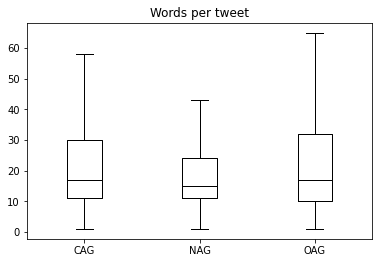

In [10]:
df['Words per tweet'] = df['Tweet'].str.split().apply(len)
df.boxplot('Words per tweet', by='Category_Name', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## Tokenizing

In [11]:
from transformers import AutoTokenizer

In [12]:

model_ckpt = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [13]:
tokenizer.vocab_size

250002

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# df_val = df_val[df_val['Category'].notna()]
# val_labs = map(lambda x : int(x), df_val['Category'])
# val_labs = list(val_labs)
# df_val['Int_Category'] = pd.Series(val_labs)

texts = list(df['Tweet'])
# val_texts = list(df_val['Tweet'])
labels = list(df['Category'])
# val_labels = list(df_val['Category'])


In [16]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
     texts, labels, test_size=0.2, random_state=43)

In [17]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [18]:
import torch

class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
train_dataset = TwitterDataset(train_encodings, train_labels)
val_dataset = TwitterDataset(val_encodings, val_labels)

In [20]:
# Tokenizing batch input
def tokenize(batch):
  bt = list(batch['Tweet'])
  return tokenizer(bt, padding=True, truncation=True)

In [21]:
# Checking first two rows of our dataset
print(tokenize(aggressions['train'][:2]))

{'input_ids': [[0, 4263, 27759, 111, 68360, 2301, 25, 18, 5646, 81113, 22631, 26548, 9098, 7068, 33662, 68360, 1221, 186, 98, 70, 5078, 6953, 5609, 9077, 2, 1, 1, 1, 1, 1, 1], [0, 1061, 5036, 642, 3714, 5, 581, 24793, 5608, 186, 1379, 70, 173, 379, 5, 88949, 10, 115, 6492, 23295, 83, 7228, 47, 5351, 450, 442, 25, 7, 21185, 5, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [22]:
# Encoding whole batch
aggressions_encoded = aggressions.map(tokenize, batched=True, batch_size=None)
print(aggressions_encoded['train'].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['Tweet', 'Category', 'input_ids', 'attention_mask']


## Fine-tuning

In [23]:
import torch

In [33]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [24]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if 
                      torch.cuda.is_available() else 'cpu')
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [25]:
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix

In [26]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1':f1}

In [27]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [28]:
from transformers import Trainer, TrainingArguments

In [29]:
# Defining hyperparameters
batch_size = 16
logging_steps = len(aggressions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-aggression"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=1.5e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error')

In [32]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [30]:
trainer = Trainer(model=model, args=training_args,
compute_metrics = compute_metrics,
train_dataset = train_dataset,
eval_dataset = val_dataset,
tokenizer = tokenizer)

trainer.train()


/content/drive/MyDrive/NLP_Project/project+/xlm-roberta-base-finetuned-aggression is already a clone of https://huggingface.co/SkyR/xlm-roberta-base-finetuned-aggression. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.931181,0.550836,0.555132
2,0.966700,0.902379,0.596023,0.594472


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.931181,0.550836,0.555132
2,0.966700,0.902379,0.596023,0.594472
3,0.815900,0.918615,0.608224,0.608940


TrainOutput(global_step=1662, training_loss=0.8691875030848093, metrics={'train_runtime': 19920.1397, 'train_samples_per_second': 1.333, 'train_steps_per_second': 0.083, 'total_flos': 6984871900425216.0, 'train_loss': 0.8691875030848093, 'epoch': 3.0})

## Predictions and Results

In [ ]:
# before_tweets = pd.read_csv('tc_b.csv')
# after_tweets = pd.read_csv('tc_a.csv')

In [31]:
trying = pd.read_csv('tc14_b _labelled.csv')

In [ ]:
# before_labels = list(before_tweets['Category'])
# before_texts = list(before_tweets['Tweet'])

# after_labels = list(after_tweets['Category'])
# after_texts = list(after_tweets['Tweet'])

In [32]:
trying_labels = list(trying['Category'])
trying_texts = list(trying['Tweet'])

In [ ]:
# before_encodings = tokenizer(before_texts, truncation=True, padding=True)
# after_encodings = tokenizer(after_texts, truncation=True, padding=True)

In [33]:
trying_encodings = tokenizer(trying_texts, truncation=True, padding=True)


In [ ]:
# before_dataset = TwitterDataset(before_encodings, before_labels)
# after_dataset = TwitterDataset(after_encodings, after_labels)

In [34]:
trying_dataset = TwitterDataset(trying_encodings, trying_labels)


In [ ]:
# preds_output_before = trainer.predict(before_dataset)
# preds_output_after = trainer.predict(after_dataset)

In [35]:
preds_output_trying = trainer.predict(trying_dataset)


In [ ]:
# preds_output_before.metrics

In [ ]:
# preds_output_after.metrics

In [37]:
preds_output_trying.metrics

{'test_accuracy': 0.5728571428571428,
 'test_f1': 0.5768618431854121,
 'test_loss': 0.8741624355316162,
 'test_runtime': 27.1317,
 'test_samples_per_second': 25.8,
 'test_steps_per_second': 1.622}

In [ ]:
# y_preds_before = np.argmax(preds_output_before.predictions, axis=1)

In [ ]:
# y_preds_after = np.argmax(preds_output_after.predictions, axis=1)

In [45]:
y_preds_trying = np.argmax(preds_output_trying.predictions, axis=1)

In [ ]:
# y_valid_before = np.array(before_dataset.labels)
# y_valid_after = np.array(after_dataset.labels)

In [46]:
y_valid_trying = np.array(trying_dataset.labels)

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# y_valid_before = map(lambda x : dt[x], y_valid_before)
# y_valid_before = list(y_valid_trying)

# y_preds_before = map(lambda x : dt[x], y_preds_before)
# y_preds_before = list(y_preds_before)

# cm = confusion_matrix(y_valid_before, y_preds_before)

# f = sns.heatmap(cm, annot=True, fmt='d')

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : dt[x], y_valid_trying)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : dt[x], y_preds_trying)
y_preds_trying = list(y_preds_trying)

cm = confusion_matrix(y_valid_trying, y_preds_trying)

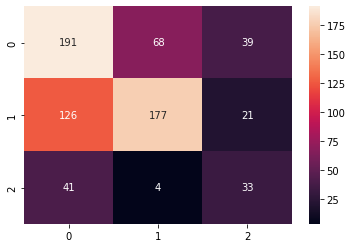

In [48]:
f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# y_valid_after = map(lambda x : dt[x], y_valid_after)
# y_valid_after = list(y_valid_after)

# y_preds_after = map(lambda x : dt[x], y_preds_after)
# y_preds_after = list(y_preds_after)

# cm = confusion_matrix(y_valid_after, y_preds_after)

# f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# before_dt = {'NAG':0, 'CAG':0, 'OAG':0}
# after_dt = {'NAG':0, 'CAG':0, 'OAG':0}

# for l in y_preds_before:
#   before_dt[l] += 1

# for l in y_preds_after:
#   after_dt[l] += 1

# print('Before election tweet predictions')
# print(before_dt)

# print('After election tweet predictions')
# print(after_dt)